# Model Fitness: Predicción y Retención de Clientes en un Gimnasio con Machine Learning

# Contexto
Con el fin de combatir la cancelación, Model Fitness ha digitalizado varios de sus perfiles de clientes. La tarea consiste en analizarlos y elaborar una estrategia de retención de clientes.

Tengo que:

* Aprender a predecir la probabilidad de pérdida (para el próximo mes) para cada cliente.
* Elaborar retratos de usuarios típicos: selecciona los grupos más destacados y describe sus características principales.
* Analizar los factores que más impactan la pérdida.
* Sacar conclusiones básicas y elaborar recomendaciones para mejorar la atención al cliente:
    * identificar a los grupos objetivo;
    * sugerir medidas para reducir la rotación;
    * describir cualquier otro patrón que observes con respecto a la interacción con los clientes.

## Carguemos los datos

In [4]:
#importamos librerias a usar
import pandas as pd
import numpy as np 
import scipy.stats as st
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [5]:
datos = pd.read_csv('datasets/gym_churn_us.csv') #Cargamos los datos

## Análisis Exploratorio de los Datos

In [6]:
datos.info() #echemos un vistazo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [7]:
datos.columns = datos.columns.str.lower() #Convertimos a minúsculas el encabezado de columnas

datos['month_to_end_contract'].value_counts() #¿Los meses para que venza el contrato están en decimales?

month_to_end_contract
1.0     2207
6.0      645
12.0     524
11.0     181
5.0      130
10.0      82
9.0       73
4.0       58
8.0       38
7.0       25
3.0       23
2.0       14
Name: count, dtype: int64

In [8]:
datos['month_to_end_contract'] = datos['month_to_end_contract'].astype('int64') #cambiamos a enteros los meses

print(datos.info())
print()
print(datos.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [9]:
#tratamiento de datos duplicados y ausentes

print("La cantidad de datos duplicados idénticos es:", datos.duplicated().sum())
print()
print('Valores ausentes:')
print(datos.isna().sum())

La cantidad de datos duplicados idénticos es: 0

Valores ausentes:
gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64


In [10]:
#No tenemos datos ausentes ni duplicados
#Echemos un vistazo extra
datos.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [11]:

print(datos.groupby(['churn']).mean().reset_index()) #observemos los valores promedio de los grupos que cancelaron(1) y los que no(0)

   churn    gender  near_location   partner  promo_friends     phone  \
0      0  0.510037       0.873086  0.534195       0.353522  0.903709   
1      1  0.510839       0.768143  0.355325       0.183789  0.902922   

   contract_period  group_visits        age  avg_additional_charges_total  \
0         5.747193      0.464103  29.976523                    158.445715   
1         1.728558      0.268615  26.989632                    115.082899   

   month_to_end_contract  lifetime  avg_class_frequency_total  \
0               5.283089  4.711807                   2.024876   
1               1.662582  0.990575                   1.474995   

   avg_class_frequency_current_month  
0                           2.027882  
1                           1.044546  


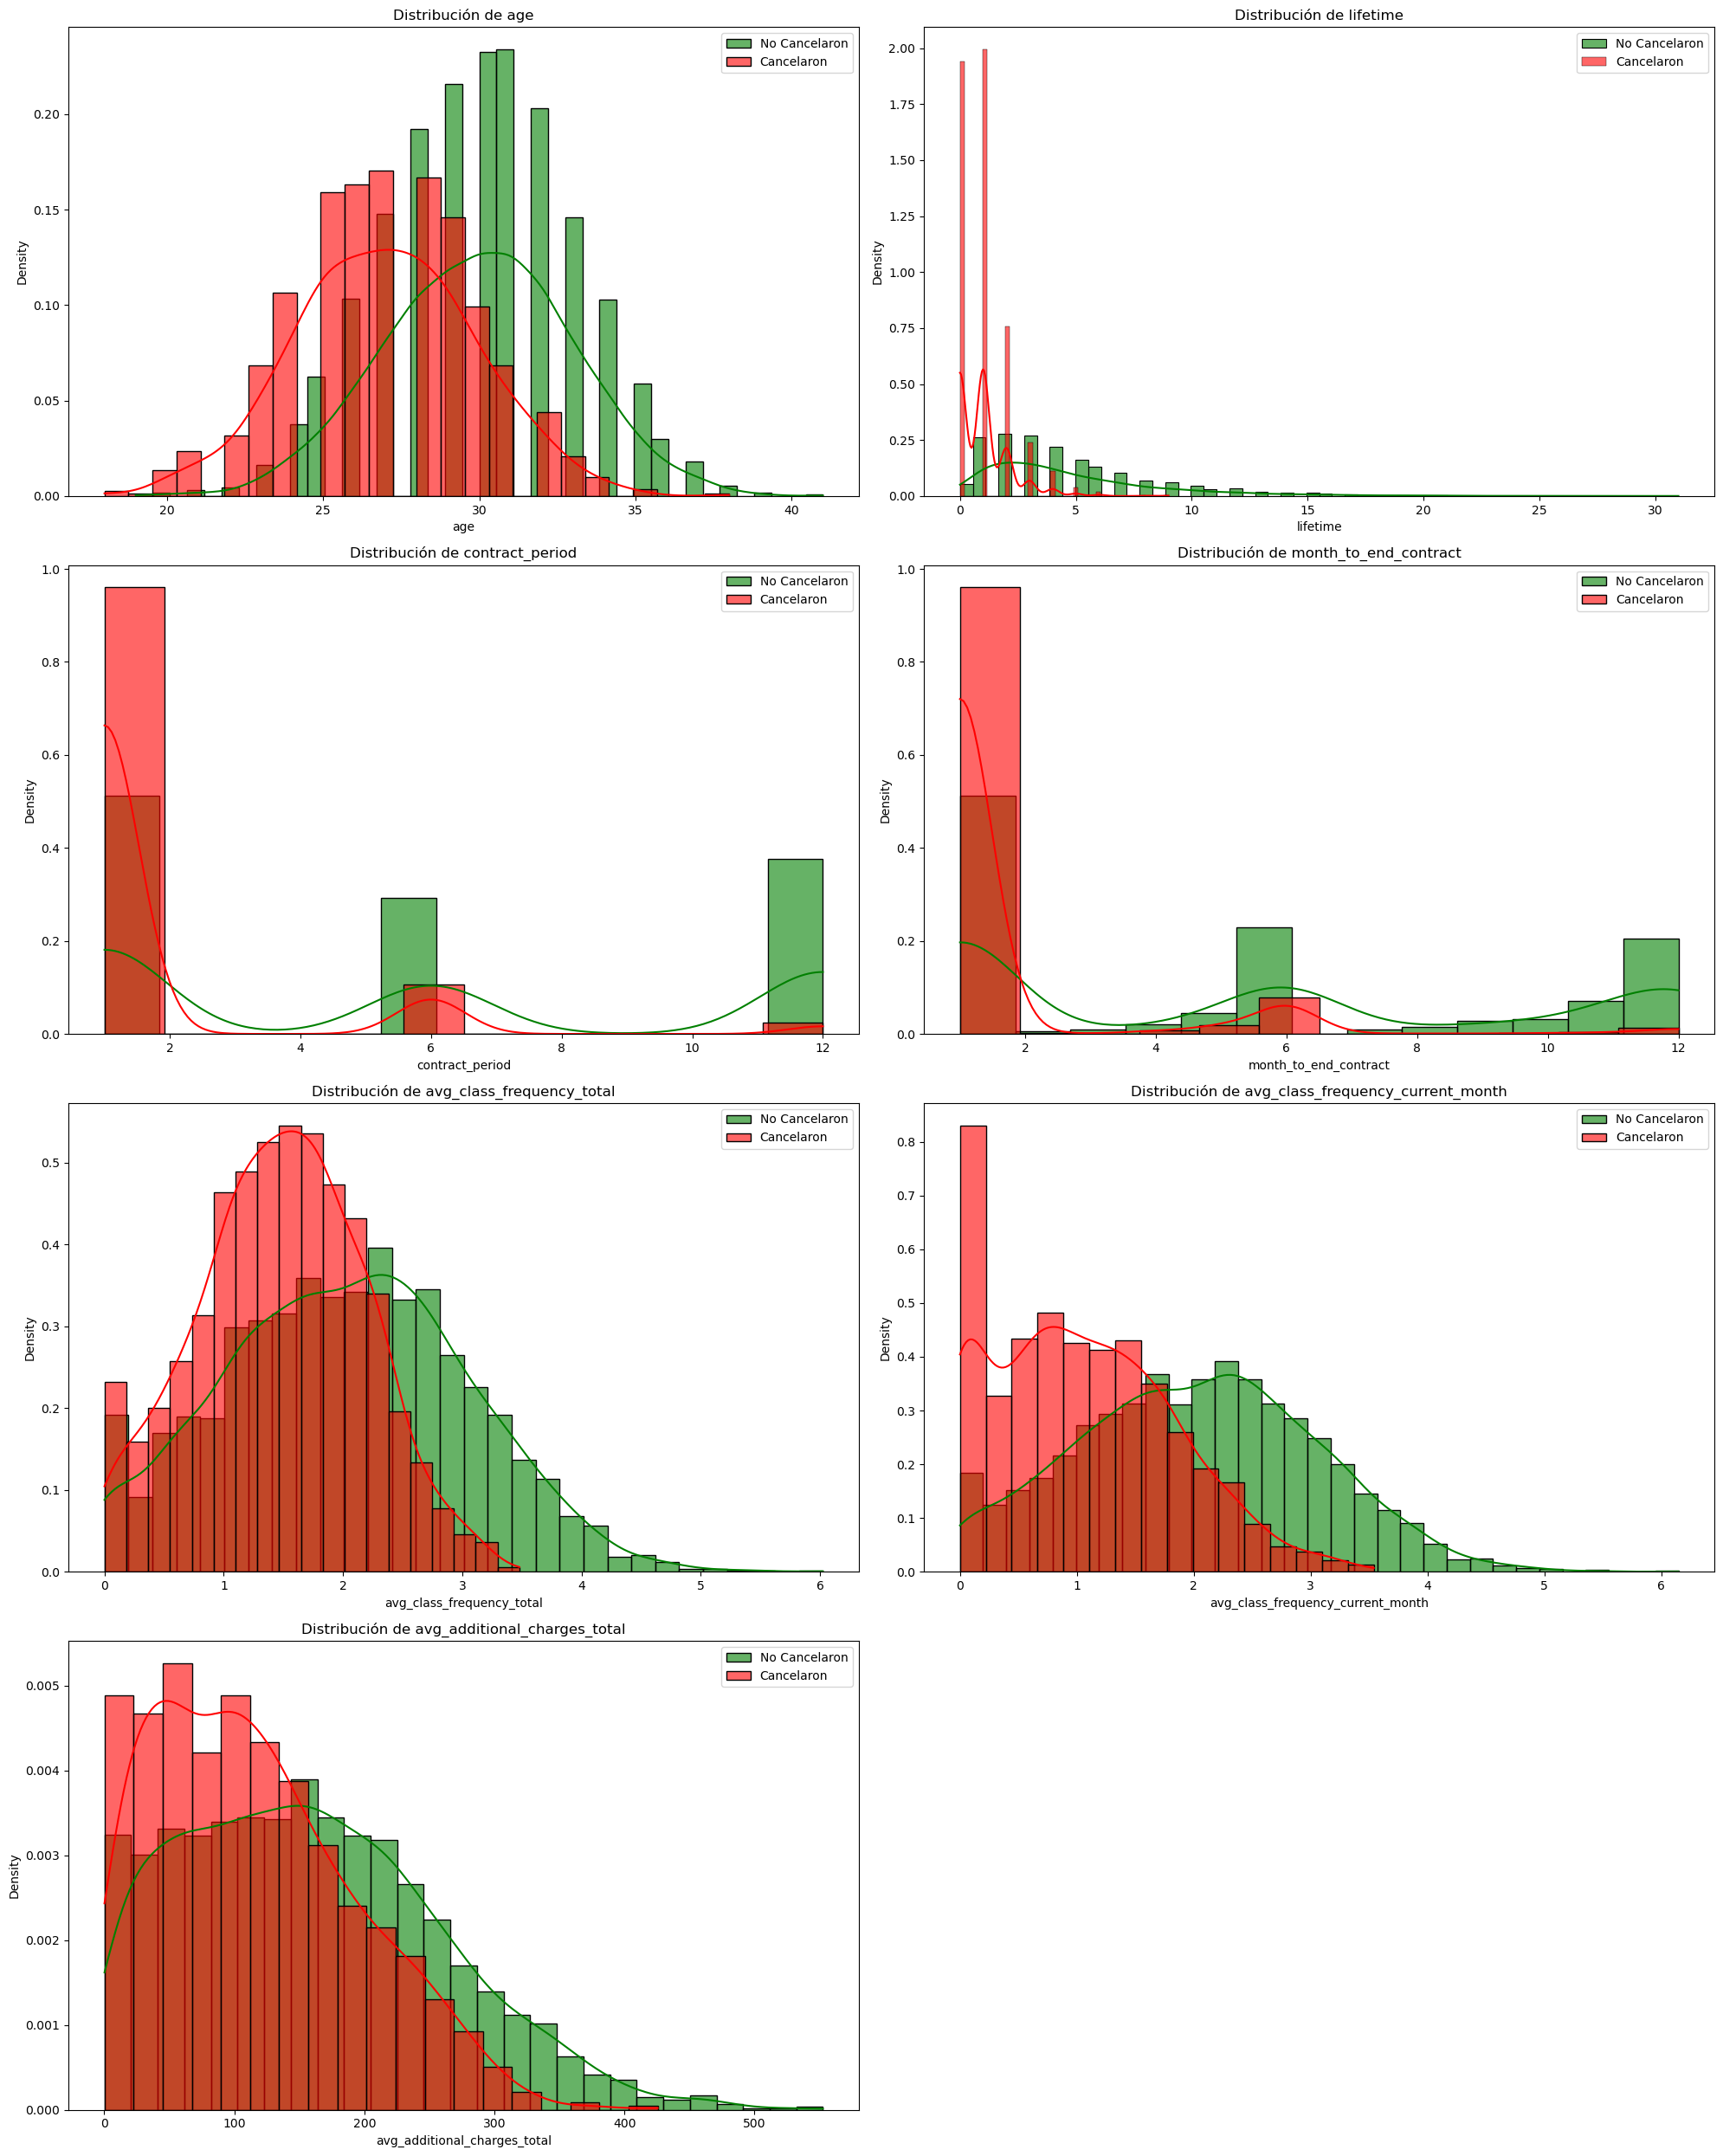

In [12]:
#Creamos dos grupos, los que cancelaron y no

churned = datos[datos['churn']==1]
not_churned = datos[datos['churn']==0]

variables_numericas = [ 'age', 'lifetime', 'contract_period', 'month_to_end_contract',
    'avg_class_frequency_total', 'avg_class_frequency_current_month',
    'avg_additional_charges_total']

#Grafiquemos solo las variables numericas
plt.figure(figsize=(20,25))

for i, column in enumerate(variables_numericas):
    plt.subplot(4,2,i+1)
    sns.histplot(not_churned[column], color='green', label='No Cancelaron', kde=True, stat='density', alpha=0.6)
    sns.histplot(churned[column], color='red', label='Cancelaron', kde=True, stat='density', alpha=0.6)
    plt.title(f'Distribución de {column}')
    plt.legend()
    
plt.tight_layout()
plt.show()

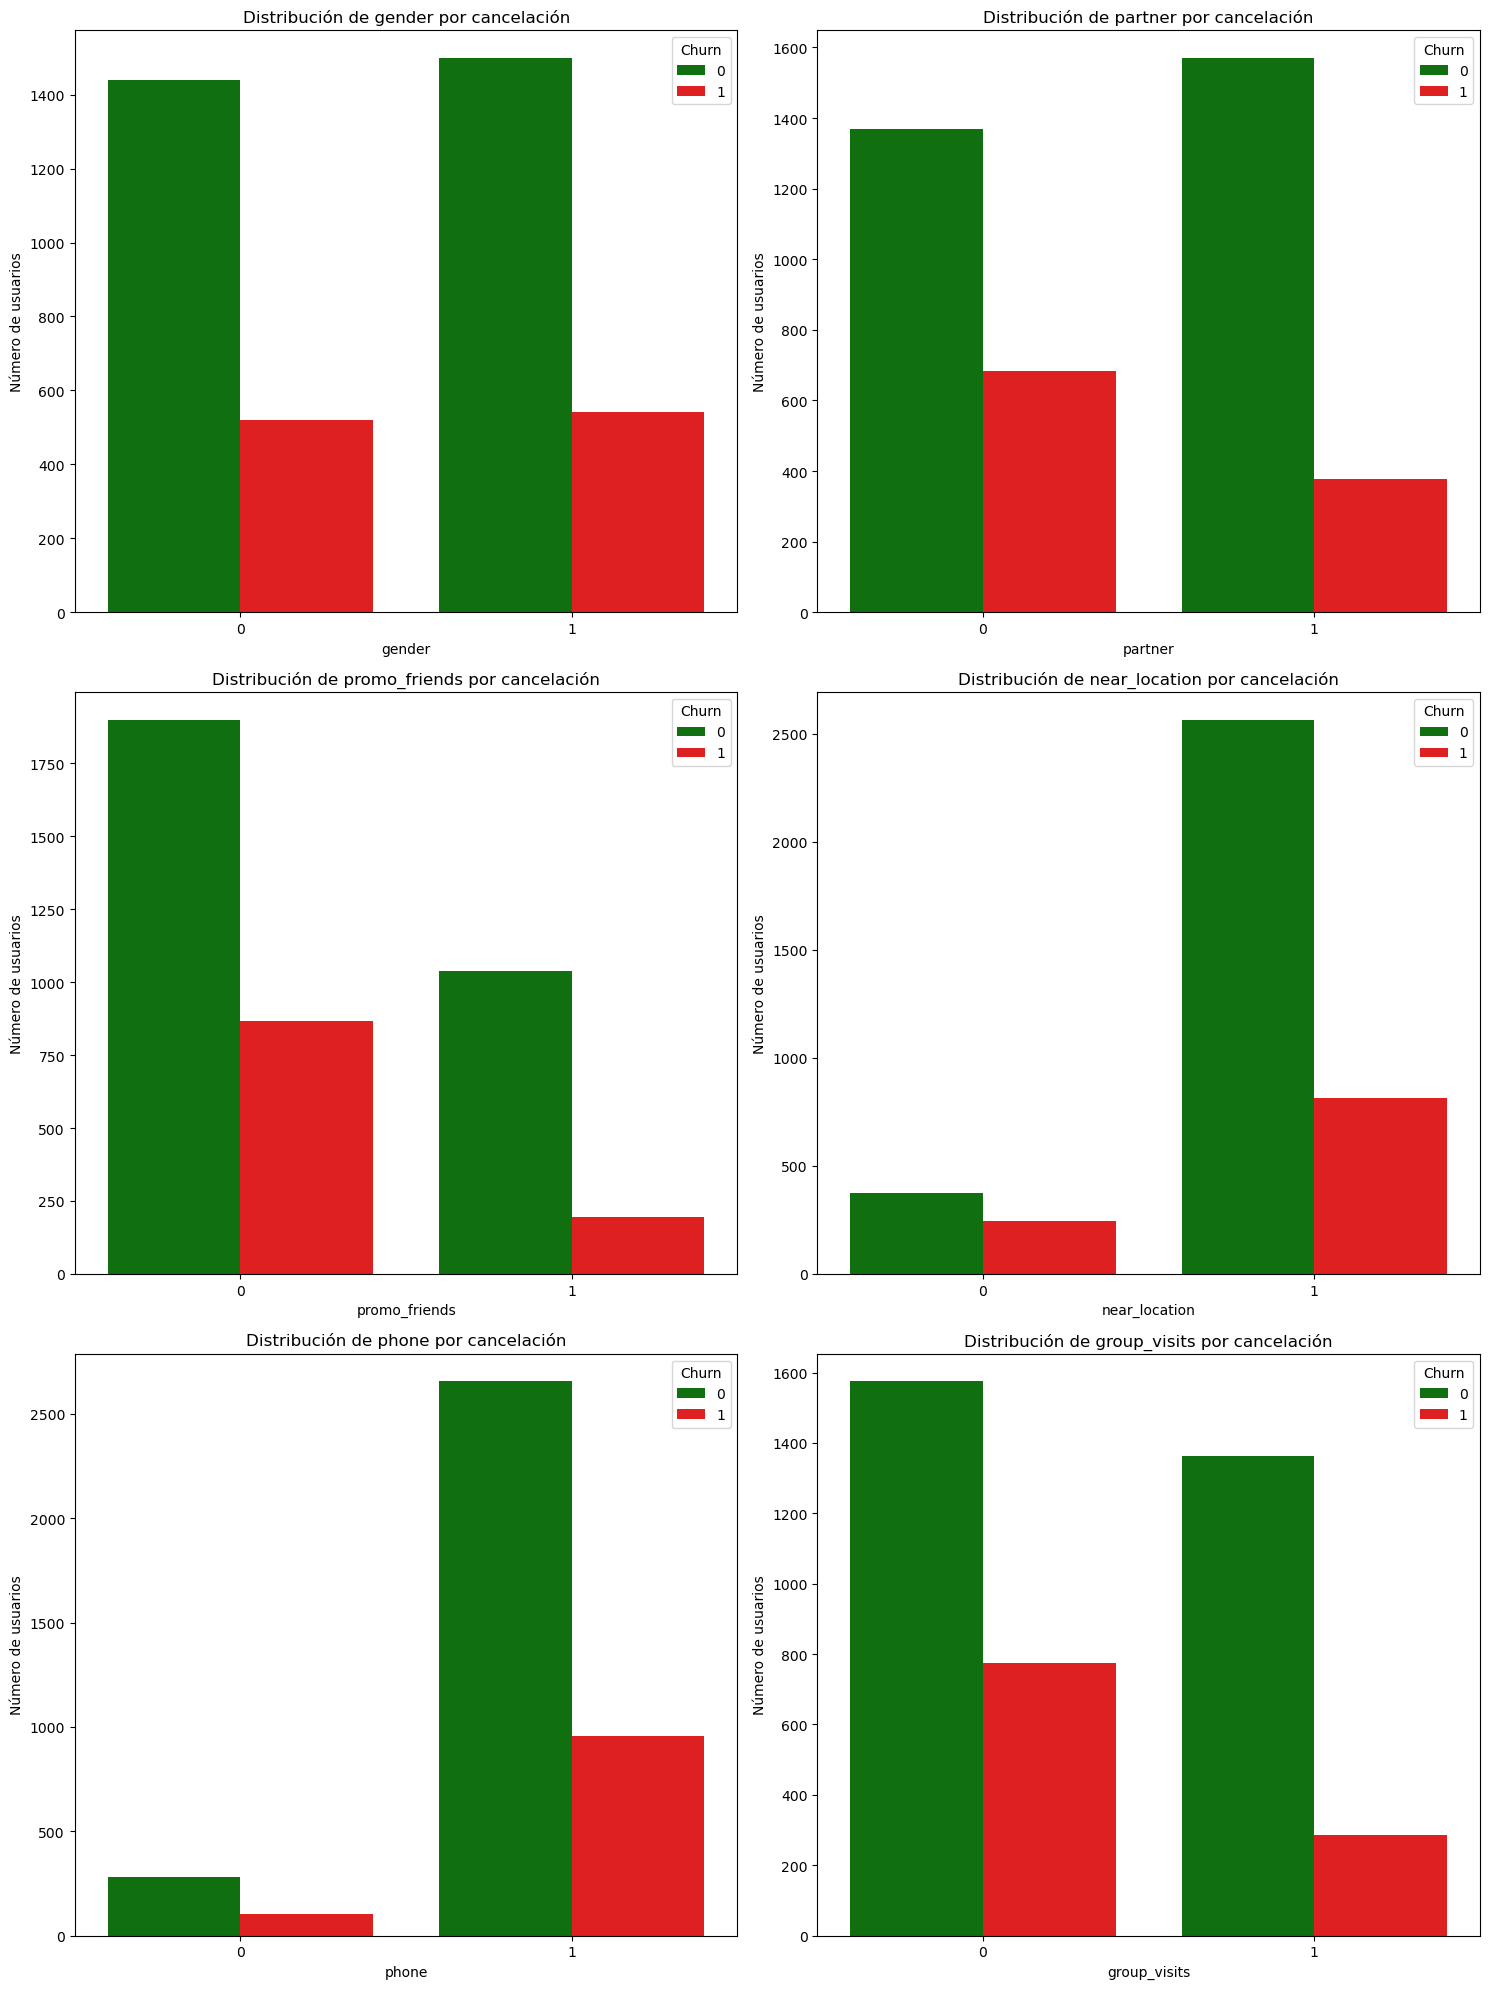

In [13]:
# Lista de variables categóricas
variables_categoricas = ['gender', 'partner', 'promo_friends', 'near_location', 'phone', 'group_visits']


plt.figure(figsize=(15, 20))

# Recorremos cada categoría con su índice para posicionar las gráficas
for i, feature in enumerate(variables_categoricas):
    plt.subplot(3, 2, i+1) 
    sns.countplot(data=datos, x=feature, hue='churn', palette={0: 'green', 1: 'red'})  # graficamos con color según cancelación
    plt.title(f'Distribución de {feature} por cancelación')
    plt.xlabel(feature)
    plt.ylabel('Número de usuarios')
    plt.legend(title='Churn')

plt.tight_layout()
plt.show()

**Conclusiones de los gráficos**

Para las características categóricas:

* Los valores promedio de gender y phone  para las personas cancelaron y no, son prácticamente iguales, parece que no son factores decisivos para cancelar. 
* Para near_location, el valor promedio es ligeramente mayor cuando para aquellos que no cancelan, o sea que viven cerca, algo lógico, entre más lejos vivas del gimnasio menos serán las ganas de ir a él. 
* Quienes se inscribieron a través del promo_friends o son partner, presentan una tasa de cancelación es menor, lo cual sugiere que las promociones y beneficios influyen positivamente en la retención. 
* Y si tienen visitas grupales también presentan una proporción mayor a no cancelar, parece que el factor social ayuda a evitar la deserción.

Para las variables numéricas podemos inferir qué:

* Las personas que cancelan son más jóvenes (\~27 años) que los que no (~30 años), las personas más maduras se preocupan por su salud. 
* El valor promedio del lifetime para los que cancelan es cercano a 1 mes y para los que no cancelan es de 4.7 meses, lo que refleja una mayor fidelidad con el paso del tiempo
* Y el tipo de contratos en orden descendente para las personas que cancelan es de 2, 6 y 12 pero, la proporción de las personas que no cancelan tienen valores bastante parecidos para 2 y 12 meses, con una ligera variación hacia abajo para los 6 meses. 
* De igual forma las personas que no abandonan gastan un poco más, aprox 40 dólares más.
* Finalmente, en términos de frecuencia, los usuarios que se quedan asisten al gimnasio más seguido: unas 2 veces por semana, frente a 1.4 veces (promedio general) y 1.04 veces (último mes) por parte de quienes cancelan.


In [14]:
datos.corr() #creemos una matriz de correlación


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


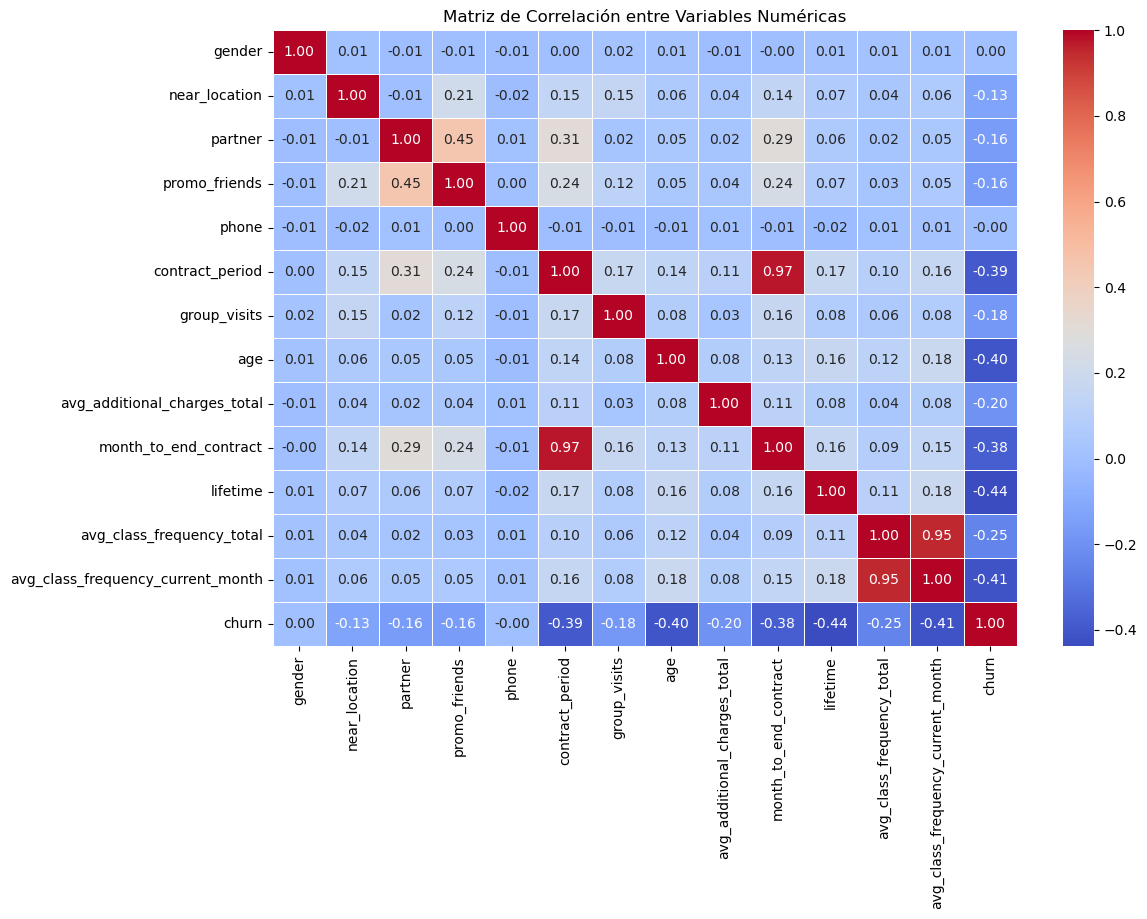

In [15]:
#visualización de la matriz de correlación
plt.figure(figsize=(12, 8))  
sns.heatmap(datos.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación entre Variables Numéricas')
plt.show()

**Conclusión**

Podemos ver que hay una  correlación inversamente proporcional de churn con contract_period, age, month_to_end_contract, lifetime y avg_class_frequency_current_month.

Y una correlación menor, tambiéne inversamente proporcional de churn con group_visits, avg_additional_charges_total y avg_class_frequeancy_total.

## Construyamos un modelo para predecir la cancelación de usuarios

### Modelo de Regresión Logística

In [16]:
#dividamos los datos en características (la matriz X) y una variable objetivo (y)

X = datos.drop('churn', axis=1)
y = datos['churn']

#dividamos los datos para el entrenamiento y para la prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Estandarizamos
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

#definimos el modelo
m1 = LogisticRegression(random_state=0)

#entrenamos el modelo
m1.fit(X_train_st, y_train)

# utilizamos el modelo entrenado para hacer las previsiones
predictions_m1 = m1.predict(X_test_st)
probabilities_m1 = m1.predict_proba(X_test_st)[:,1]

# muestra todas las métricas estudiadas para la predicción resultante
print("Regresión Lógica")
print("================")
print('Exactitud: {:.2f}'.format(accuracy_score(y_test, predictions_m1)))
print('Precisión: {:.2f}'.format(precision_score(y_test, predictions_m1)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions_m1)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions_m1)))

Regresión Lógica
Exactitud: 0.92
Precisión: 0.85
Recall: 0.83
F1: 0.84


### RandomForest

In [17]:
#Ahora el modelo de RandomForest

m2 = RandomForestClassifier(n_estimators=100, random_state=0)
m2.fit(X_train, y_train)

# utilizamos el modelo entrenado para hacer las previsiones
predictions_m2 = m2.predict(X_test)
probabilities_m2 = m2.predict_proba(X_test)[:,1]

# muestra todas las métricas estudiadas para la predicción resultante
print("RandomForestClassifier")
print("=======================")
print('Exactitud: {:.2f}'.format(accuracy_score(y_test, predictions_m2)))
print('Precisión: {:.2f}'.format(precision_score(y_test, predictions_m2)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions_m2)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions_m2)))

RandomForestClassifier
Exactitud: 0.92
Precisión: 0.84
Recall: 0.82
F1: 0.83


### Extra

In [18]:
#veamos como se comportan los modelos cambiando el umbral

# mira la relación entre las clases del dataset
print('La relación entre las clases:\n', datos['churn'].value_counts())

La relación entre las clases:
 churn
0    2939
1    1061
Name: count, dtype: int64


In [19]:
#Regresión Lógica con umbral personalizado
threshold = 0.4
probabilities_m1 = np.array(probabilities_m1)

# calcula la predicción sobre la base de las probabilidades y la relación entre las clases
custom_predictions = [0 if i<threshold else 1 for i in probabilities_m1] # escribe tu código aquí

# muestra todas las métricas para la predicción con un nuevo umbral

print('Métricas para Regresión Lógica con umbral personalizado')
print("=======================================================")
print('Accuracy for custom: {:.2f}'.format(accuracy_score(y_test, custom_predictions)))
print('Precision for custom: {:.2f}'.format(precision_score(y_test, custom_predictions)))
print('Recall for custom: {:.2f}'.format(recall_score(y_test, custom_predictions)))
print('F1 for custom: {:.2f}'.format(f1_score(y_test, custom_predictions)))

Métricas para Regresión Lógica con umbral personalizado
Accuracy for custom: 0.92
Precision for custom: 0.82
Recall for custom: 0.85
F1 for custom: 0.83


In [20]:
#RandomForest con umbral personalizado
threshold = 0.4 
probabilities_m2 = np.array(probabilities_m2)

# calcula la predicción sobre la base de las probabilidades y la relación entre las clases
custom_predictions = [0 if i<threshold else 1 for i in probabilities_m2] # escribe tu código aquí

# muestra todas las métricas para la predicción con un nuevo umbral
print('Métricas para RandomForest con umbral personalizado')
print("====================================================")
print('Accuracy for custom: {:.2f}'.format(accuracy_score(y_test, custom_predictions)))
print('Precision for custom: {:.2f}'.format(precision_score(y_test, custom_predictions)))
print('Recall for custom: {:.2f}'.format(recall_score(y_test, custom_predictions)))
print('F1 for custom: {:.2f}'.format(f1_score(y_test, custom_predictions)))

Métricas para RandomForest con umbral personalizado
Accuracy for custom: 0.92
Precision for custom: 0.80
Recall for custom: 0.88
F1 for custom: 0.84


**Conclusión**

¿Qué modelo es mejor y por qué?

En este caso, yo recomendaría el modelo de RandomForest con el umbral personalizado, ya que nos interesa identificar a todos aquellos usuarios que se quieran ir, por esto le daría mayor peso al Recall, una métrica que nos dice la sensibilidad del modelo para detectar a aquellos que se quieran ir, sacrificando un poco la precisión ya que seguro tendremos más falsos positivos de personas que se quieran ir, pero aún así podriamos realizar una estrategia con estos usuarios para intentar retenerlos.

## Crear clústeres de Usuarios

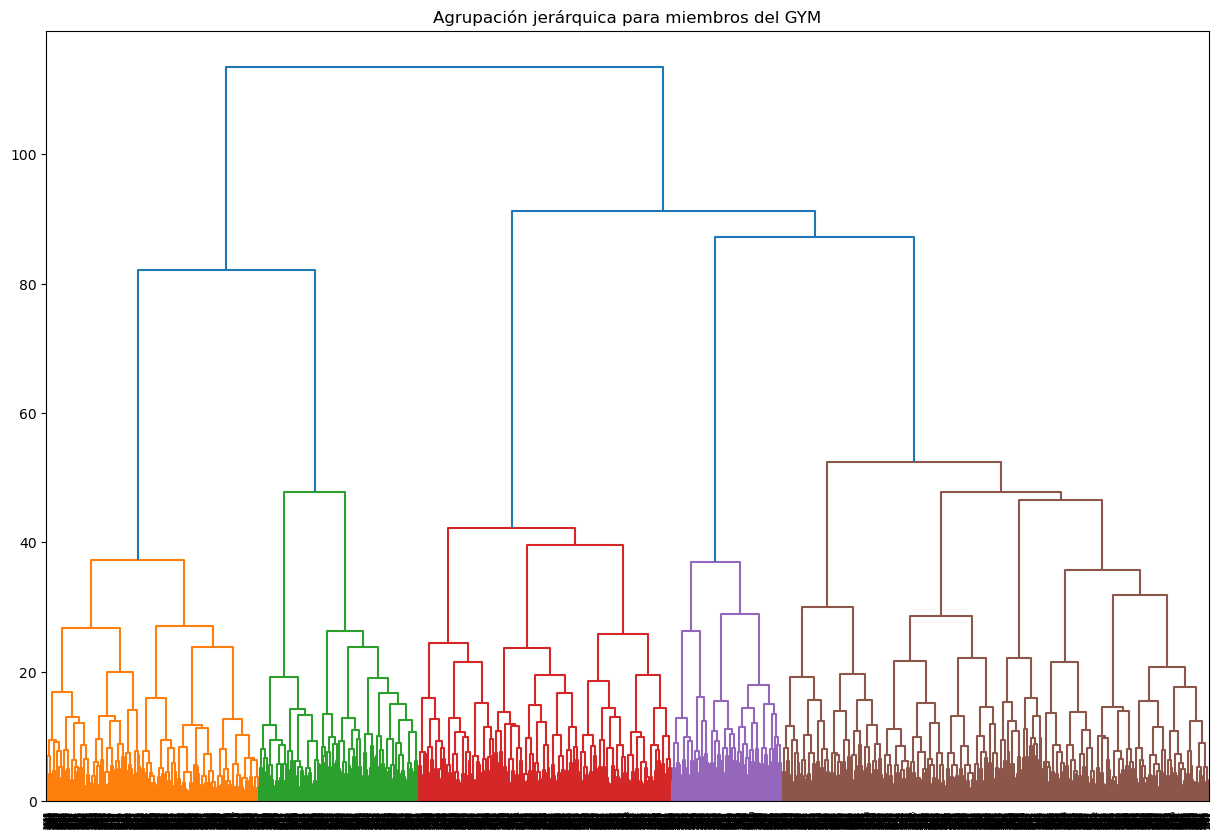

In [21]:
# la estandarización de datos obligatoria antes de pasarlo al algoritmo
sc = StandardScaler()
X_sc = sc.fit_transform(datos)

linked = linkage(X_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Agrupación jerárquica para miembros del GYM')
plt.show()

In [22]:
# define el modelo k_means con 5 clústeres
km = KMeans(n_clusters=5)
# predice los clústeres para las observaciones (el algoritmo les asigna un número de 0 a 4)
labels = km.fit_predict(X_sc)

# almacena etiquetas de clúster en el campo de nuestro conjunto de datos
datos['cluster_km'] = labels

# obtiene las estadísticas de los valores medios de las características por clúster
print(datos.groupby(['cluster_km']).mean())

              gender  near_location   partner  promo_friends     phone  \
cluster_km                                                               
0           0.498084       0.000000  0.467433       0.074713  0.913793   
1           0.470944       0.998789  0.427361       0.294189  0.891041   
2           0.513222       0.946131  0.764936       0.550441  0.899119   
3           0.550898       0.950898  0.367665       0.257485  0.918563   
4           0.512563       1.000000  0.329146       0.219849  0.899497   

            contract_period  group_visits        age  \
cluster_km                                             
0                  2.160920      0.206897  28.421456   
1                  2.817191      0.417676  30.004843   
2                 11.365328      0.559256  29.895201   
3                  2.855090      0.469461  30.112575   
4                  1.610553      0.292714  26.947236   

            avg_additional_charges_total  month_to_end_contract  lifetime  \
cluster_km 

**Conclusión de los clústeres**
 
 Los clústeres que más llaman la atención son el 0, 1 y 2, ya que estos tienen una tasa de cancelación mayor comparada con los demás.
 
 El Cluster 0, no vive cerca, no viene de la promo_friends, su contrato es de aprox 2 meses, solo el 20% va a clases grupales y un lifetime de 2.8 meses, al mes van 1.5 veces por semana, este grupo tiene una probabilidad del 43% de cancelar, un riesgo medio-alto.
 
 El Cluster 1, viven cerca, el 22% viene de la promo_friends, su contrato es de 1.6 meses aprox, el 28% va a clases grupales y son los más jóvenes de 27 años, tienen un valor promedio de apenas un mes en el gimnasio y una visita a la semana por mes, con una probabilidad de cancelar del 93% un riesgo altísimo. 
 
 El Cluster 2, el 86% vive cerca, 47% viene de la promo_friends, tienen un contrato promedio de 4.7 meses y el 42% va a clases grupales y 4.4 meses para terminar sus contratos y llevan 4 meses en el gimnasio y van en promedio 1.75 veces por semana al gimnasio, tienen una probabilidad de cancelar del 26%, un riesgo medio.
 
 Los Cluster 3 y 4, tienen una probabilidad de cancelación bajísimas, las características que comparten es un mayor porcentaje va a clases grupales y al menos van 2 veces por semana al gimnasio y llevan más de 4.5 meses en el gimnasio.

**Grafiquemos las características por cluster**

C:\Users\osval\AppData\Local\Temp\ipykernel_5484\900335602.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_km', y=col, data=datos, palette='Set2')


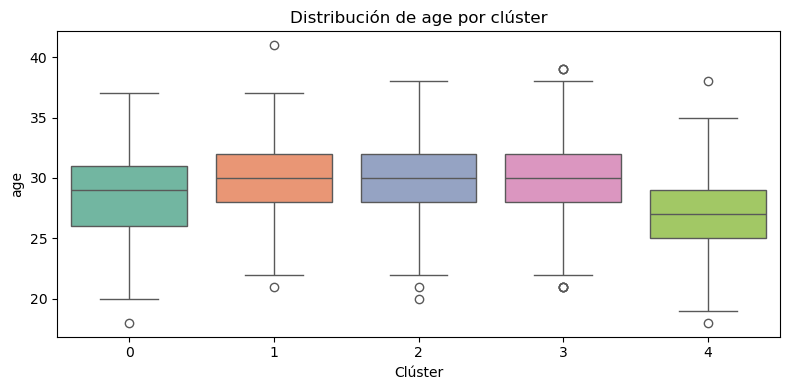

C:\Users\osval\AppData\Local\Temp\ipykernel_5484\900335602.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_km', y=col, data=datos, palette='Set2')


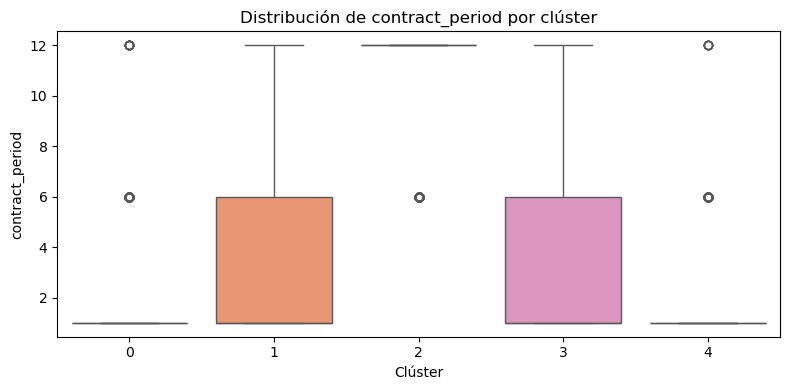

C:\Users\osval\AppData\Local\Temp\ipykernel_5484\900335602.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_km', y=col, data=datos, palette='Set2')


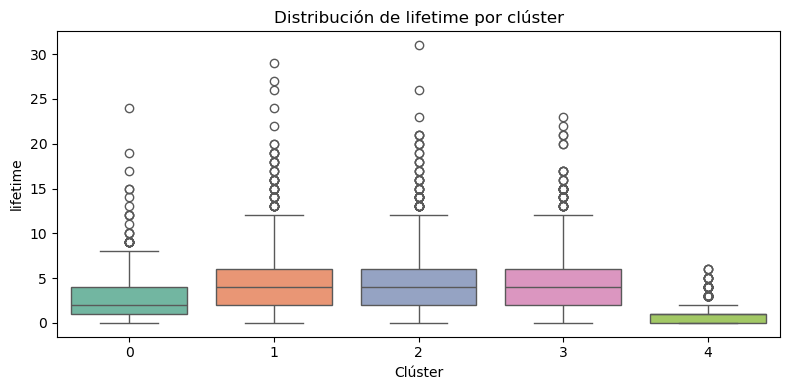

C:\Users\osval\AppData\Local\Temp\ipykernel_5484\900335602.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_km', y=col, data=datos, palette='Set2')


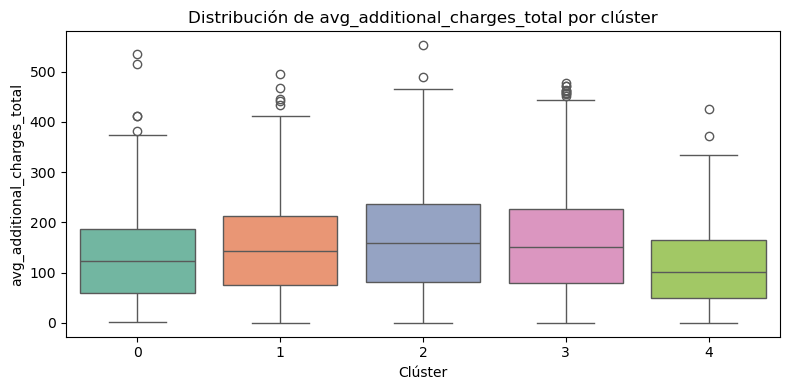

C:\Users\osval\AppData\Local\Temp\ipykernel_5484\900335602.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_km', y=col, data=datos, palette='Set2')


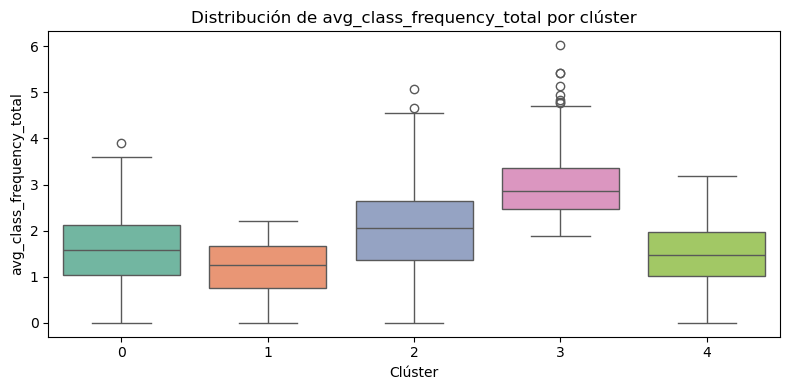

C:\Users\osval\AppData\Local\Temp\ipykernel_5484\900335602.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_km', y=col, data=datos, palette='Set2')


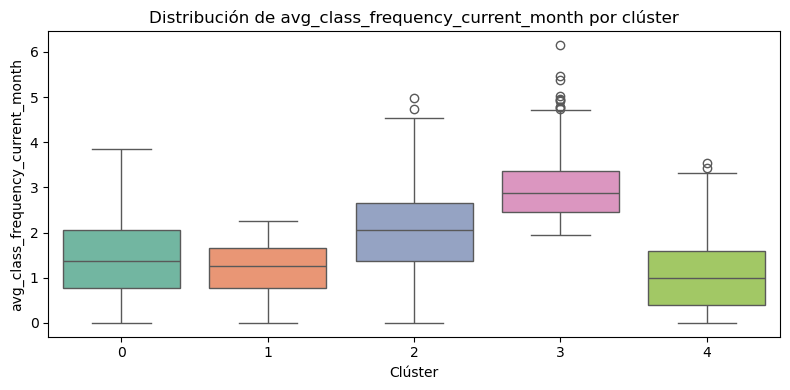

C:\Users\osval\AppData\Local\Temp\ipykernel_5484\900335602.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_km', y=col, data=datos, palette='Set2')


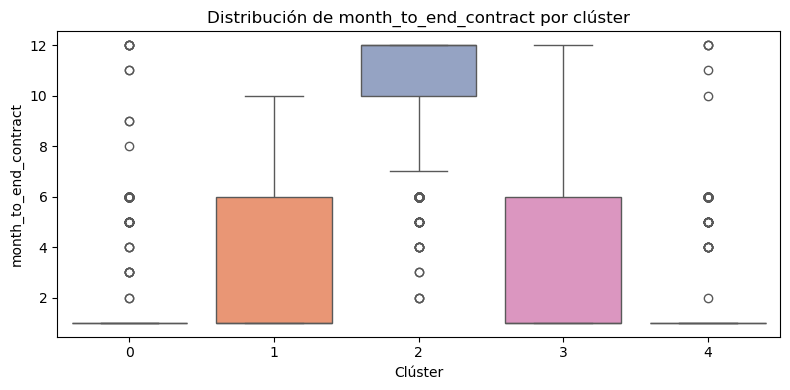

In [23]:
quant_cols = [
    'age', 'contract_period', 'lifetime',
    'avg_additional_charges_total', 
    'avg_class_frequency_total', 'avg_class_frequency_current_month',
    'month_to_end_contract'  # incluimos churn
]

# Gráficas por variable
for col in quant_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='cluster_km', y=col, data=datos, palette='Set2')
    plt.title(f'Distribución de {col} por clúster')
    plt.xlabel('Clúster')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

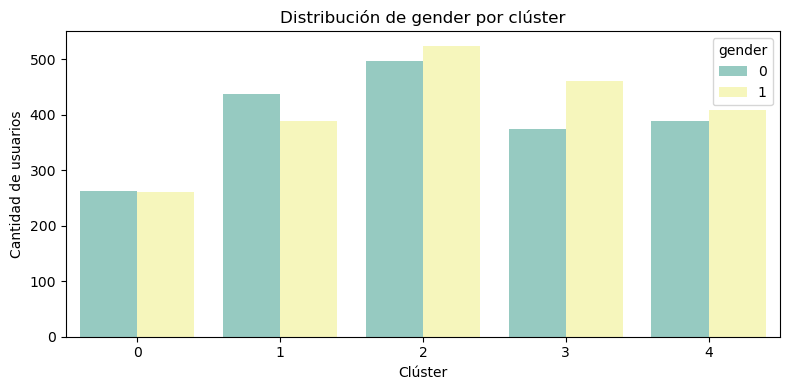

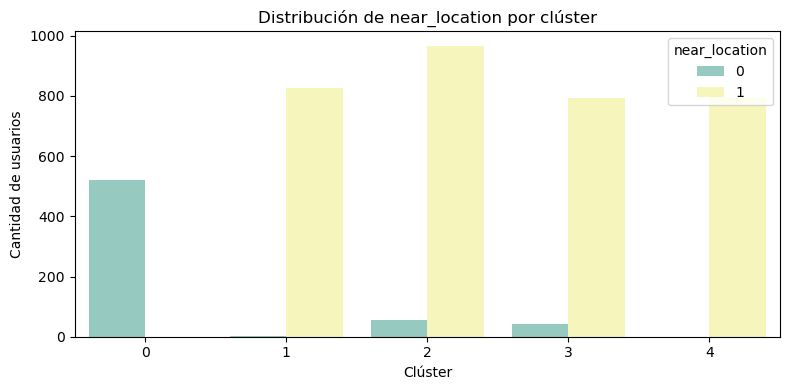

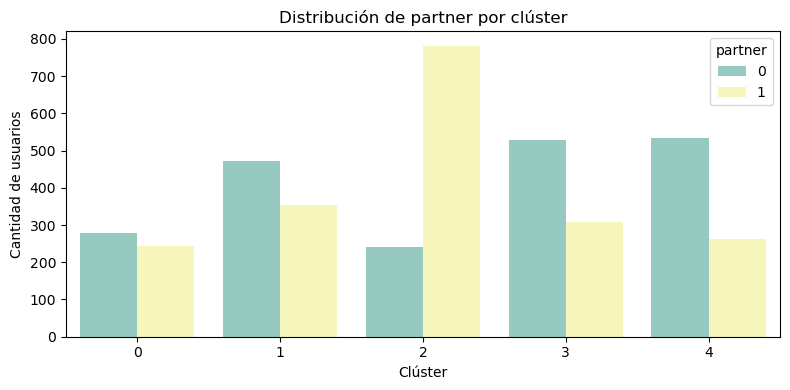

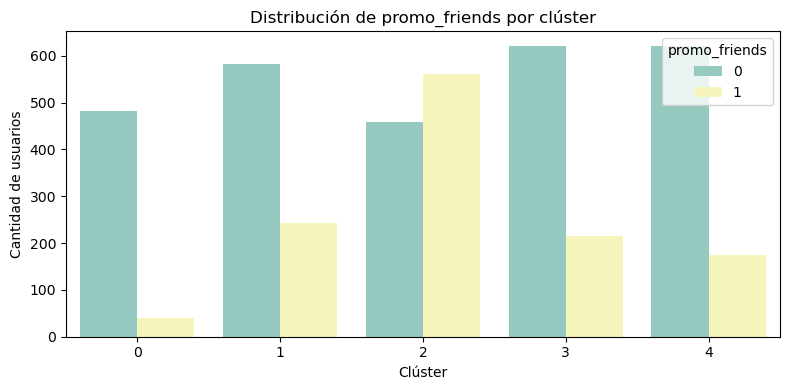

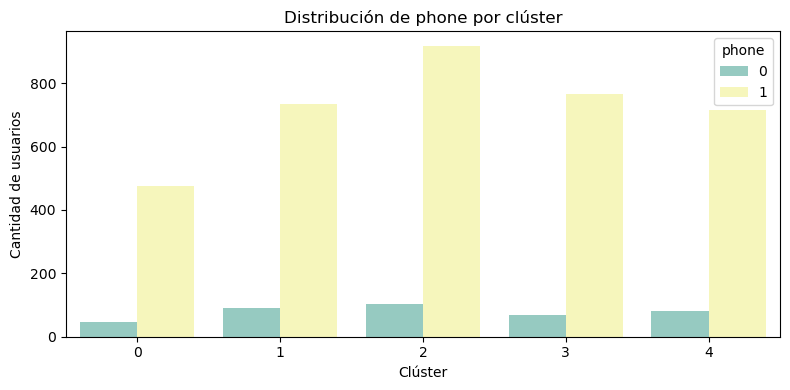

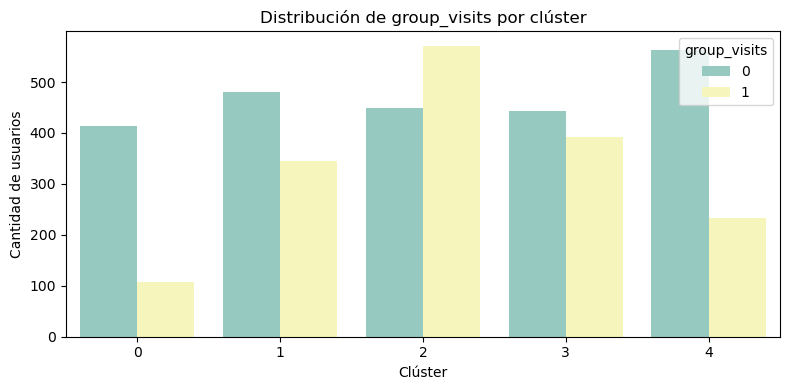

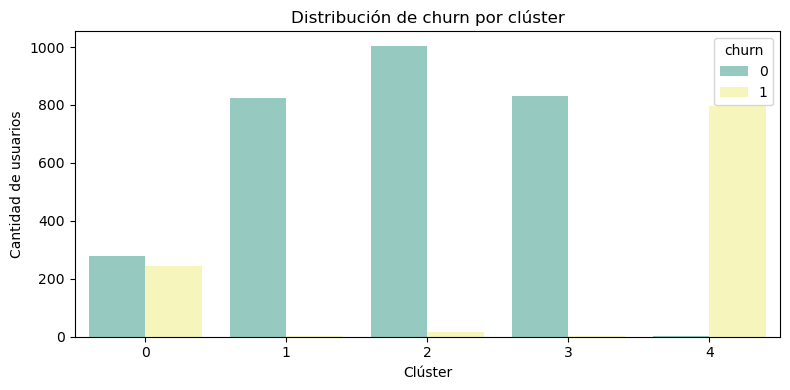

In [24]:
cat_cols = [
    'gender', 'near_location', 'partner', 
    'promo_friends', 'phone', 'group_visits', 'churn'
]

# Graficamos distribución de frecuencias por clúster
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x='cluster_km', hue=col, data=datos, palette='Set3')
    plt.title(f'Distribución de {col} por clúster')
    plt.xlabel('Clúster')
    plt.ylabel('Cantidad de usuarios')
    plt.legend(title=col, loc='upper right')
    plt.tight_layout()
    plt.show()

Ahora podemos ver la distribución de características entre Clúster, en especial **churn**

##  Conclusiones y  recomendaciones básicas sobre el trabajo con clientes

Hemos hecho un modelo con RandomForest cuyas características son:

* Accuracy for custom: 0.92
* Precision for custom: 0.80
* Recall for custom: 0.88
* F1 for custom: 0.84

Puede que la precisión no parezca suficiente pero esto es intencional, ya que el modelo tiene un Recall alto, es decir es altamente sensible, detecta a los usuarios que se van aunque eso implique algunos falsos positivos. 

Y ahora sabemos las características de 5 clústeres (ó 5 tipos de usuarios), donde los 3 primeros tienen mayor probabilidad a abandonar y comparten ciertas características como vivir lejos de la sucursal, baja tasa para ir a clases grupales, contratos cortos y asistencia semanal baja.

Con esta información puede realizarse marketing para retener a los usuarios, tipo: Promociones para que acudan a clases grupales, relocalización de otra sucursal más cercana, promociones para contratos de periodos más grandes o incentivos para asistir a clases. 